# Using `ncbi.datasets` library to download annotation and parse GFF3 files 

Here, we will use `ncbi.datasets` to download annotation data for some assemblies and parse them to extract specific information.  

Specifically, 
1. query NCBI for _Lactobacillus_ assemblies and download the assembly descriptors for all available assemblies
2. parse assembly descriptors to make a list of assemblies annotated in 2020
3. download genome sequence and annotation (gff3 and protein fasta) for those assemblies
4. parse gff3 files to extract information about crispr genes
  1. use that information to extract gene sequences from genome fasta files 
  2. use that information to extract protein sequences from protein fasta files 

## Setup

In [1]:
import ncbi.datasets
import zipfile
import pandas as pd
import gffutils
from pyfaidx import Fasta
from collections import defaultdict, Counter
import json
from textwrap import dedent

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
## start api_instance and dl_instance
api_instance = ncbi.datasets.AssemblyDatasetDescriptorsApi(ncbi.datasets.ApiClient())
dl_instance = ncbi.datasets.DownloadApi(ncbi.datasets.ApiClient())

## Tabulate data from GFF3 files

Using the `ncbi.datasets` library, we first check the number of available assemblies for a taxid of interest to us

In [3]:
## set taxid
taxid = 1578 ## lactobacillus

In [4]:
api_response = api_instance.assembly_descriptors_by_taxid(
    tax_id = taxid,
    limit = 'NONE',
    filters_refseq_only = True)

In [5]:
## total count of results
ct = api_response.total_count
print(f"Number of assemblies: {ct}")

Number of assemblies: 2797


In [6]:
%%time
## download assembly descriptors for all of them
api_response = api_instance.assembly_descriptors_by_taxid(
    tax_id = taxid,
    limit = 'all',
    filters_refseq_only = True)

CPU times: user 1.47 s, sys: 45.1 ms, total: 1.51 s
Wall time: 2.32 s



WARNING!
Some assemblies do not have annotation. 
Most likely, this is because of an indexing delay. Skipping 6 assemblies.



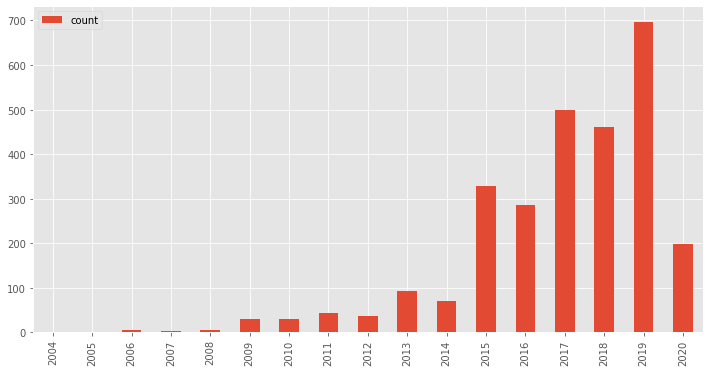

In [7]:
## tabulate annotations by year and plot the data 
annots_by_year = Counter()
no_annot_assms = []
for d in api_response.datasets:
    if d.annotation_metadata:
        annot_year = int(d.annotation_metadata.release_date.split(' ')[-1])
        annots_by_year[annot_year] += 1
    else:
        no_annot_assms.append(d.assembly_accession)

if len(no_annot_assms) > 0:
    print(dedent(f'''
    WARNING!
    Some assemblies do not have annotation. 
    Most likely, this is because of an indexing delay. Skipping {len(no_annot_assms)} assemblies.
'''))

df = pd.DataFrame.from_dict(annots_by_year, orient='index', columns=['count']).sort_index()
df.plot(kind='bar', y='count', figsize=(12,6))

In [8]:
chosen_year = 2020
assm_accs = []
for d in api_response.datasets:
    if d.annotation_metadata:
        annot_year = int(d.annotation_metadata.release_date.split(' ')[-1])
        if annot_year == chosen_year:
            assm_accs.append(d.assembly_accession)
        
print(f'{len(assm_accs)} assemblies were annotated in {chosen_year}.')

199 assemblies were annotated in 2020.


In [9]:
%%time
## download data
dl_response = dl_instance.download_assembly_package(
    assm_accs,
    include_sequence=True,
    include_annotation_type=['GENOME_GFF', 'PROT_FASTA'],
    _preload_content=False )

## write to a zip file 
zipfn = 'ncbi_genomes.zip'
with open(zipfn, 'wb') as f:
    f.write(dl_response.data)

CPU times: user 2.34 s, sys: 1.38 s, total: 3.72 s
Wall time: 1min 45s


In [10]:
## parse data catalog 
with zipfile.ZipFile(zipfn, 'r') as zip:
    data_catalog = json.loads(zip.read('ncbi_dataset/data/dataset_catalog.json'))

In [11]:
## function to make list of files 
def get_file_list(filetype):
    if filetype.upper() not in ['FASTA', 'DATA_REPORT', 'GFF3']:
        print(f'ERROR! filetype {filetype} is invalid.')
    else:
        filetype = filetype.upper()
        
    file_list = defaultdict(list)
    for asm in data_catalog['assemblies']:
        acc = asm['accession']
        for f in asm['files']:
            if f['fileType'] == filetype:
                fpath = f['filePath']
                file_list[acc].append(fpath)
        
    return file_list

In [12]:
## there's a bug that labels all annotation files as fileType GFF3
gff3_file_list = get_file_list('gff3')
genome_file_list = get_file_list('fasta')

In [13]:
## setting up files and directories

## temporary files; will be deleted at the end
temp_dir = 'tempfiles'
temp_gff = temp_dir + '/temp.gff'
temp_fa = temp_dir + '/temp.fa'

!mkdir -p {temp_dir}

## final output files 
genes_fn = 'crispr_genes.fna'
prots_fn = 'crispr_proteins.faa'

In [14]:
%%time
blessed_genes = set(['cas3', 'cse1', 'cse2', 'cas7', 'cas5', 'cas6', 'cas4', 'cas1', 'cas2', 'cas5', 'cas8', 'cas9', 'csn2'])
crispr_order = defaultdict(list)

## create empty files to add data to
open(genes_fn, 'w').close()
open(prots_fn, 'w').close()

with zipfile.ZipFile(zipfn, 'r') as zip:
    for assm_acc, filelist in gff3_file_list.items():
        crispr_genes = dict()

        ## extract gff3 to a temp file 
        data = zip.read('ncbi_dataset/data/' + filelist[1])
        with open(temp_gff, 'wb') as f:
            f.write(data)

        ## create gff3 db in memory
        ## okay for bacterial assemblies but use caution
        ## when parsing large assemblies like human
        db = gffutils.create_db(temp_gff, 
                                dbfn = ':memory:', 
                                force=True, 
                                keep_order=True, 
                                merge_strategy='merge', 
                                sort_attribute_values=True)

        ## parse db and extract data for blessed genes
        gene_list = []
        for f in db.all_features():
            if f.attributes['gbkey'] == ['Gene']:
                gene_list.append(f.attributes['ID'][0])

        for gene in gene_list:
            gene = db[gene]
            gene_name = gene.attributes.get('Name', None)[0]
            if gene_name[:4] in blessed_genes:
                gene_range = (gene.start, gene.end)
                if gene.attributes['gene_biotype'][0] == 'protein_coding':
                    cds = list(db.children(gene, featuretype='CDS'))
                    prot_acc = cds[0].attributes.get('protein_id', None)[0]
                else:
                    prot_acc = None
                crispr_genes[gene_name] = ([gene.chrom, gene.strand, gene_range, prot_acc])
                crispr_order[assm_acc].append(gene_name)

        ## parse genome fasta file and extract crispr gene seqs
        genome_fa = genome_file_list[assm_acc]
        data = bytearray()
        for fa in genome_fa:
            data.extend(zip.read('ncbi_dataset/data/' + fa))
        with open(temp_fa, 'wb') as f:
            f.write(data)
            
        genome = Fasta(temp_fa)
        with open(genes_fn, 'a+') as f:
            for gene_name, gene_info in crispr_genes.items():
                chrom, strand, gene_range, prot_acc = gene_info
                if strand == '+':
                    gene_fasta = genome.get_seq(chrom, gene_range[0], gene_range[1])
                elif strand == '-':
                    gene_fasta = genome.get_seq(chrom, gene_range[0], gene_range[1], rc=True)
                f.write('>' + gene_fasta.fancy_name + '|' + gene_name + '\n')
                f.write(gene_fasta.seq + '\n')

        ## parse protein fasta file and extract crispr protein seqs
        data = zip.read('ncbi_dataset/data/' + gff3_file_list[assm_acc][0])
        with open(temp_fa, 'wb') as f:
            f.write(data)
        proteome = Fasta(temp_fa, read_long_names=False)
        with open(prots_fn, 'a+') as f:
            for gene_name, gene_info in crispr_genes.items():
                chrom, strand, gene_range, prot_acc = gene_info
                if prot_acc is not None:
                    prot_fasta = proteome[prot_acc][:]
                    f.write('>' + prot_fasta.name + '|' + gene_name + '\n')
                    f.write(prot_fasta.seq + '\n')

CPU times: user 4min 45s, sys: 4.17 s, total: 4min 50s
Wall time: 5min 5s


In [15]:
## remove temporary files 

!rm -rvf {temp_dir}

removed ‘tempfiles/temp.gff’
removed ‘tempfiles/temp.fa’
removed ‘tempfiles/temp.fa.fai’
rm: cannot remove ‘tempfiles’: Directory not empty


In [16]:
## order of crispr genes in various assemblies
for k,v in crispr_order.items():
    print(k, v)

GCF_009832765.1 ['csn2', 'cas2', 'cas1', 'cas9']
GCF_009834385.1 ['csn2', 'cas2', 'cas1', 'cas9']
GCF_009834405.1 ['cas9']
GCF_009857225.1 ['csn2']
GCF_009857395.1 ['cas3', 'cas7e', 'cas5e', 'cas6e', 'cas1e', 'cas2e']
GCF_009863295.1 ['csn2', 'cas2', 'cas1', 'cas9']
GCF_009863365.1 ['cas9', 'cas1', 'cas2', 'csn2']
GCF_009863375.1 ['cas9', 'cas1', 'cas2', 'csn2']
GCF_009863405.1 ['cas6', 'cas10', 'cas1', 'cas2', 'cas9', 'cas1', 'cas2', 'csn2']
GCF_009863415.1 ['cas6', 'cas10', 'cas1', 'cas2', 'csn2', 'cas2', 'cas1', 'cas9']
GCF_009863435.1 ['cas2', 'cas1', 'cas10', 'cas6', 'csn2', 'cas2', 'cas1', 'cas9']
GCF_009863465.1 ['cas2', 'cas1', 'cas10', 'cas6', 'cas9', 'cas1', 'cas2', 'csn2']
GCF_009863485.1 ['cas9', 'cas1', 'cas2', 'csn2']
GCF_009863495.1 ['csn2', 'cas2', 'cas1', 'cas9']
GCF_009863515.1 ['cas2', 'cas1', 'cas10', 'cas6', 'cas9', 'cas1', 'cas2', 'csn2']
GCF_009863535.1 ['cas9', 'cas1', 'cas2', 'csn2']
GCF_009863555.1 ['cas1', 'cas2', 'csn2', 'cas9']
GCF_009863585.1 ['cas2', 'cas